<a href="https://colab.research.google.com/github/1712307/ImageProcessingAtUniversity/blob/master/EdgeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





Một vài kết luận về các thuật toán phát hiện biên cạnh (Edge Detection)
- Toán tử Prewit có thể tách sườn đứng tốt hơn toán tử Sobel 
- Sobel tách sườn trên các điểm ở đường chéo tốt hơn 
- => Các kĩ thuật sử dụng phương pháp Gradient khá tốt.
- Ưu điểm: Hiệu quả cao khi độ sáng có tốc độ thay đổi nhanh và đơn giản trên cơ sở các mặt nạ theo các ướng 
- Nhược điểm: Nhạy nhiễu, tạo biên kép 

- Laplace tốt hơn Gradient: Khi mức xám biến đổi chậm, miền chuyển đổi mức xám có độ trải rộng. Biên tìm được mảnh (1px)
(Cũng như Gradient, Laplace cũng nhạy với nhiễu)

**Phương pháp CANNY**

B0: Import thư viện và load ảnh lên

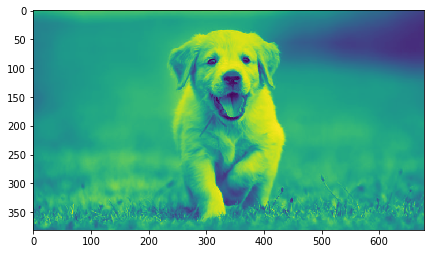

In [0]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(7,5))
im = cv.imread('cho.jpeg')
im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(im)

B1: Khử nhiễu (Noise Reduce)
Dùng Gaussian G(x, y, ơ ) * f (x, y)

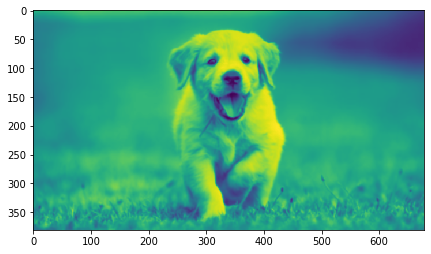

In [0]:
def GaussianKenel(size,sigma = 1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    #Ham np.mgrip tra ve mot ma tran voi x la so dong tang, y la so cot tang
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
def getKernel(im,x,y,size):
    result = np.zeros([size,size])
    result.fill(im[x, y])
    tmp = int(size) // 2
    for i in range(-tmp,tmp+1):
        for j in range(-tmp,tmp+1):
            if x + i >= 0 and x + i  <= im.shape[0] -1 and y + j >= 0 and y + j <= im.shape[1] -1:
                result[i + tmp,j +tmp] = im[x + i,y + j]
    return result      
def SmoothImageByGaussian(im,size):
    gausskernel = GaussianKenel(size) #Khoi tao Kernel 
    g = np.zeros(im.shape)
    rows = im.shape[0]
    columns = im.shape[1]
    for i in range(0,rows):
        for j in range(0,columns):
            g[i,j] = np.sum(getKernel(im,i,j,size) * gausskernel)
    return g
g = SmoothImageByGaussian(im,5)
plt.figure(figsize=(7,5))
plt.imshow(g)

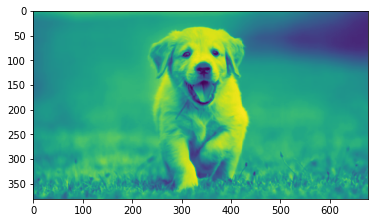

In [0]:
#Sử dụng thư viện Python 
import cv2
kernelX = cv2.getGaussianKernel(5, 1)
kernelY = cv2.getGaussianKernel(5, 1)
kernel = kernelX * kernelY.T
cv2_output = cv2.filter2D(im, cv2.CV_8U, kernel)
plt.imshow(cv2_output)

B2: Gradient Calculation + B4: Tính biên độ cạnh

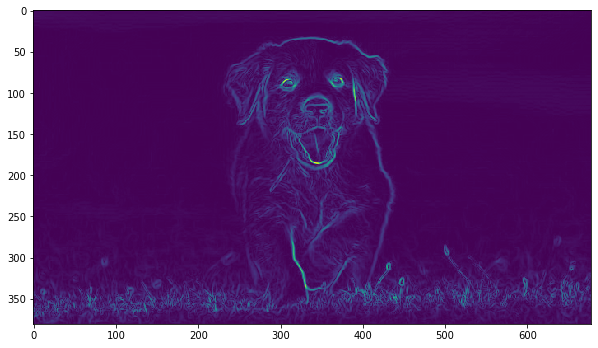

In [0]:
def sobel_filters(img):
    # Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    # Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    gx = np.zeros(im.shape)
    gy = np.zeros(im.shape)
    g = np.zeros(im.shape)
    rows = im.shape[0]
    columns = im.shape[1]
    for i in range(0,rows):
        for j in range(0,columns):
            K = getKernel(im,i,j,3); 
            gx[i,j] = 0.25 * (K[0,2]+ 2*K[1,2]+K[2,2] - (K[0,0]+2*K[1,0]+K[2,0]))
            gy[i,j] = 0.25 * (K[0,0]+2*K[0,1]+K[0,2] - (K[2,0]+2*K[2,1]+K[2,2]))
            g[i,j] = np.sqrt((gx[i,j])*(gx[i,j]) + (gy[i,j])*(gy[i,j]))
    return g,gx,gy
b2,Gx,Gy = sobel_filters(im)
plt.figure(figsize=(10,10))
plt.imshow(b2)

**B3: Non Maximal Supression**

Non-maximum Suppression (viết tắt NMS): loại bỏ các pixel ở vị trí không phải cực đại toàn cục. Ở bước này, ta dùng một filter 3x3 lần lượt chạy qua các pixel trên ảnh gradient. Trong quá trình lọc, ta xem xét xem độ lớn gradient của pixel trung tâm có phải là cực đại (lớn nhất trong cục bộ - local maximum) so với các gradient ở các pixel xung quanh. Nếu là cực đại, ta sẽ ghi nhận sẽ giữ pixel đó lại. Còn nếu pixel tại đó không phải là cực đại lân cận, ta sẽ set độ lớn gradient của nó về zero. Ta chỉ so sánh pixel trung tâm với 2 pixel lân cận theo hướng gradient. Ví dụ: nếu hướng gradient đang là 0 độ, ta sẽ so pixel trung tâm với pixel liền trái và liền phải nó. Trường hợp khác nếu hướng gradient là 45 độ, ta sẽ so sánh với 2 pixel hàng xóm là góc trên bên phải và góc dưới bên trái của pixel trung tâm. Tương tự cho 2 trường hợp hướng gradient còn lại. Kết thúc bước này ta được một mặt nạ nhị phân.

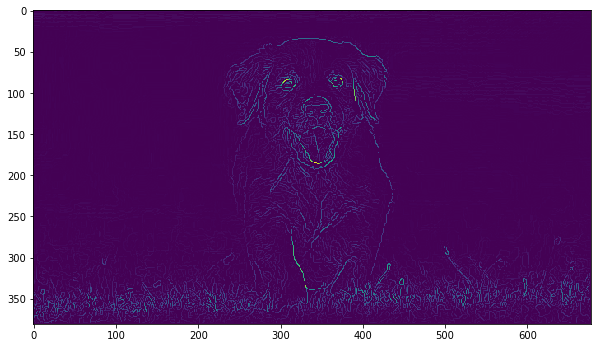

In [0]:
def non_max_suppression(img,Gx, Gy):
    M, N = img.shape
    Z = np.zeros(img.shape, dtype=np.int32)
    angle = np.arctan2(Gy, Gx) * 180. / np.pi
    angle[angle < 0] += 180   
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except:
                pass  
    return Z
b3 = non_max_suppression(b2,Gx,Gy)
plt.figure(figsize=(10,10))
plt.imshow(b3)

**B5:Lọc Threshold**

17.099999999999998


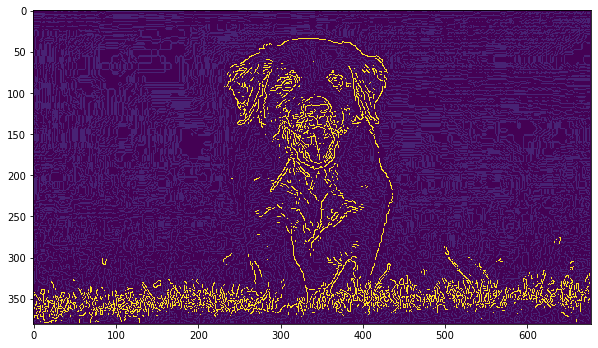

In [0]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio
    print(highThreshold)
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros(img.shape)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return res
b5 = threshold(b3)
plt.figure(figsize=(10,10))
plt.imshow(b5)